# Reporting

After calculating summary statistics, visualizing them, and testing for significant effects using inferential statistics, we must put these results together to form a narrative that explains what we have found. When reporting results, it is important to describe the results thoroughly and accurately, and in a way that is understandable to a relatively wide audience.

There are many different kinds of analyses that we may want to explore when analyzing a dataset. We will use examples from analysis of the Morton et al. (2013) dataset, to illustrate how to run and report different analyses. We will use Polars, Seaborn, and Pingouin to get the plots and statistics we need to make conclusions about the dataset.

In [1]:
import polars as pl
import seaborn as sns
import pingouin as pg
from datascipsych import datasets
data_file = datasets.get_dataset_file("Morton2013")
raw = pl.read_csv(data_file, null_values="n/a")
data = raw.filter(pl.col("study"))  # remove invalid recall attempts
data.head()

subject,session,list,item,input,output,study,recall,repeat,intrusion,list_type,list_category,category,response,response_time
i64,i64,i64,str,i64,i64,bool,bool,i64,bool,str,str,str,i64,f64
1,1,1,"""TOWEL""",1,13,true,true,0,false,"""pure""","""obj""","""obj""",3,1.517
1,1,1,"""LADLE""",2,null,true,false,0,false,"""pure""","""obj""","""obj""",3,1.404
1,1,1,"""THERMOS""",3,null,true,false,0,false,"""pure""","""obj""","""obj""",3,0.911
1,1,1,"""LEGO""",4,18,true,true,0,false,"""pure""","""obj""","""obj""",3,0.883
1,1,1,"""BACKPACK""",5,10,true,true,0,false,"""pure""","""obj""","""obj""",3,0.819


In this study, participants studied lists of 24 items, which were celebrities, famous locations, or common objects. After each list, participants were asked to freely recall the items from that list in whatever order they wanted. In the dataset, trials where the `recall` column is `true` indicate that the participant did successfully recall that item. There were two types of list: *pure* lists (all the same category) and *mixed* lists (drawn from different categories).

Next, we will demonstrate a series of analysis types using this dataset. In each case, reporting results of an analysis involves *visualizing* an effect of a variable (or lack of effect), *summarizing* the effect using summary statistics, and *testing* to see if the effect is statistically significant.

## Comparing two conditions

If we have some variable that was measured in different conditions, we may want to know if that variable changes reliably depending on the condition. We will first analyze whether recall accuracy on pure lists is different from recall accuracy on mixed lists.

### Calculating measures

We first need to calculate the mean for each condition, separately for each subject.

In [2]:
lt = (
    data.group_by("subject", "list_type")
    .agg(pl.col("recall").mean())
    .sort("subject", "list_type")
)
lt.head()

subject,list_type,recall
i64,str,f64
1,"""mixed""",0.476389
1,"""pure""",0.564815
2,"""mixed""",0.55
2,"""pure""",0.555556
3,"""mixed""",0.484722


We don't really need to sort the data, but it makes the result easier to understand.

### Visualization

 Next, we can visualize the means and uncertainty in the means using a bar plot with error bars. Seaborn will automatically calculate the means across subjects, and use a bootstrap method to determine error bars around the means.

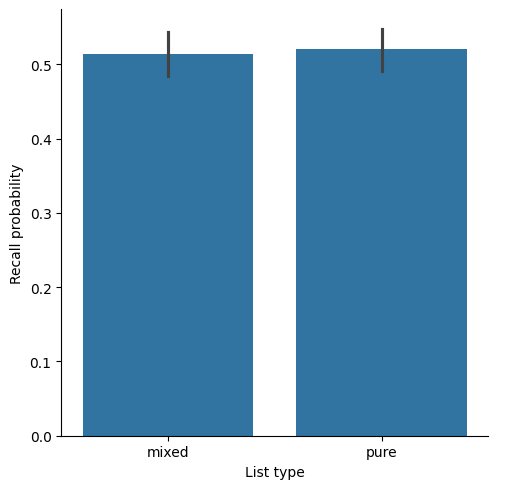

In [3]:
sns.catplot(data=lt, x="list_type", y="recall", kind="bar").set_axis_labels("List type", "Recall probability");

By default, Seaborn will label axes with the names of the columns we used, but those names aren't always the best for making a visualization; for example, they may have things like underscores in the names. We can use the `set_axis_labels` method to change the x-axis and y-axis labels to something that is easier to read.

In our report, we must include a figure *caption* to explain what's in the figure.

> Recall, measured as the fraction of items recalled in each list, was similar for pure and mixed lists. Error bars indicate 95% bootstrap confidence intervals.

### Summary statistics

In addition to having a plot showing the means, it's helpful to include the mean of each condition in the text of a report also. The standard error of the mean (SEM), which indicates uncertainty in the estimate of the mean, gives a sense of how reliable our estimate of the mean is. The SEM is defined as:

$$
\mathrm{SEM} = \frac{\sigma}{\sqrt{n}}
$$

Note that, for a given standard deviation $\sigma$, increasing the number of samples $n$ will decrease the SEM. The more samples we have, the more confident we can be in our estimate of the mean. Lower SEM indicates less *error*, or greater confidence.

In Polars, we can calculate the SEM by taking the standard deviation and dividing by the sqrt of the length of the group. We will use another pair of `group_by` and `agg` calls to get the mean and SEM for each list type.

In [4]:
(
    lt.group_by("list_type")
    .agg(
        mean=pl.col("recall").mean(),
        sem=pl.col("recall").std() / pl.col("recall").len().sqrt(),
    )
)

list_type,mean,sem
str,f64,f64
"""mixed""",0.514097,0.014944
"""pure""",0.520718,0.013915


### Inferential statistics

Finally, we use a t-test to see if there is a significant difference between conditions. We can use a pivot table to access recall for the mixed and pure lists separately.

In [5]:
p = lt.pivot("list_type", index="subject", values="recall")
pg.ttest(p["mixed"], p["pure"], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.997508,39,two-sided,0.324667,"[-0.02, 0.01]",0.072498,0.271,0.073222


Because list type is a within-subjects condition, we use a paired t-test.

### Results

We can report our findings using the figure and something like the following text.

> We examined whether there was a difference in recall between the different list types. We found that there was similar recall in the mixed (mean=0.514, SEM=0.081) and pure (mean=0.521, SEM=0.082) lists. There was not a significant difference in recall based on list type (t(39)=1.00, p=0.33, Cohen's d=0.072).

When reporting statistics, we give the mean and SEM for each condition, while providing text to help explain the results. We then report the results of the hypothesis test, giving the statistic, the degrees of freedom, the p-value, and a measure of effect size (here, Cohen's d is commonly used for t-tests).

The sign of the t-statistic is usually discarded. It depends on whether we test (mixed - pure) or (pure - mixed), but we just care about whether there is a difference. The reader can tell the direction of the (non-significant) effect by looking at the means, rather than the sign of the t-statistic.

## Comparing multiple conditions

If we have more than two conditions, we can use a one-way ANOVA to test for differences. In this example, we will examine whether recall varies depending on the *serial position* of an item. We will split up items by whether they were studied in an early position in the list (1-8), a middle position (9-16), or a late position (17-24).

### Calculating measures

First, we will have to add a new column that indicates serial position group. We can use the `cut` method, which divides a column into bins based on the boundaries we indicate. We can provide a label for each bin.

In [6]:
sp = data.with_columns(
    serial_position=pl.col("input").cut([9, 17], labels=["early", "middle", "late"])
)
sp.head(10)

subject,session,list,item,input,output,study,recall,repeat,intrusion,list_type,list_category,category,response,response_time,serial_position
i64,i64,i64,str,i64,i64,bool,bool,i64,bool,str,str,str,i64,f64,cat
1,1,1,"""TOWEL""",1,13,true,true,0,false,"""pure""","""obj""","""obj""",3,1.517,"""early"""
1,1,1,"""LADLE""",2,null,true,false,0,false,"""pure""","""obj""","""obj""",3,1.404,"""early"""
1,1,1,"""THERMOS""",3,null,true,false,0,false,"""pure""","""obj""","""obj""",3,0.911,"""early"""
1,1,1,"""LEGO""",4,18,true,true,0,false,"""pure""","""obj""","""obj""",3,0.883,"""early"""
1,1,1,"""BACKPACK""",5,10,true,true,0,false,"""pure""","""obj""","""obj""",3,0.819,"""early"""
1,1,1,"""JACKHAMMER""",6,7,true,true,0,false,"""pure""","""obj""","""obj""",1,1.212,"""early"""
1,1,1,"""LANTERN""",7,null,true,false,0,false,"""pure""","""obj""","""obj""",2,0.888,"""early"""
1,1,1,"""DOORKNOB""",8,11,true,true,0,false,"""pure""","""obj""","""obj""",3,0.915,"""early"""
1,1,1,"""SHOVEL""",9,9,true,true,0,false,"""pure""","""obj""","""obj""",1,1.287,"""early"""


Next, we calculate the mean for each subject and serial position group.

In [7]:
recency = (
    sp.group_by("subject", "serial_position")
    .agg(pl.col("recall").mean())
)

### Visualization

Now we can visualize the effect of serial position on recall. Because serial position is an ordered variable, we'll use a line plot, which connects data points instead of a bar plot, which treats conditions as having no particular order.

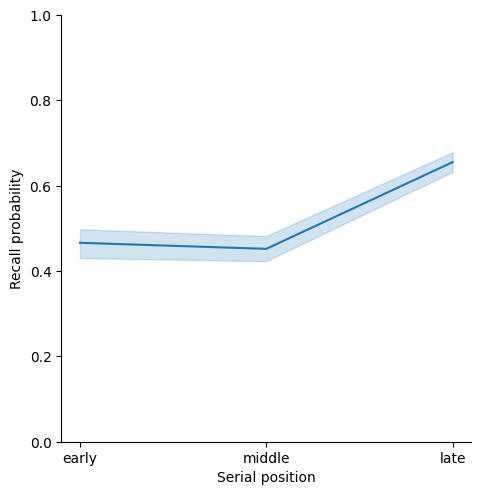

In [8]:
(
    sns.relplot(data=recency, x="serial_position", y="recall", kind="line")
    .set(ylim=(0, 1), xlabel="Serial position", ylabel="Recall probability")
);

> Recall probability varied with serial position group, with the greatest recall in late serial positions. Error band indicates 95% bootstrap confidence intervals.

### Summary statistics

We also calculate summary statistics, including the mean and SEM.

In [9]:
(
    recency.group_by("serial_position")
    .agg(
        mean=pl.col("recall").mean(),
        sem=pl.col("recall").mean() / pl.col("recall").len().sqrt(),
    )
)

serial_position,mean,sem
cat,f64,f64
"""early""",0.466146,0.073704
"""late""",0.655208,0.103598
"""middle""",0.452018,0.07147


### Inferential statistics

Finally, we test whether recall varies by serial position group. Because we have more than two groups, we have to use an ANOVA instead of a t-test.

In [10]:
pg.rm_anova(data=recency.to_pandas(), dv="recall", within="serial_position", subject="subject")

,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,serial_position,2,78,265.498022,1.554981e-35,0.490107,0.728722


### Results

We can report our results with text like this:

> We examined whether there was a difference in recall based on serial position group (early positions: 1-8; middle: 9-16; late: 17-24). Late serial positions were recalled best (mean=0.655, SEM=0.104), followed by early serial positions (mean=0.466, SEM=0.074), with the worst recall for middle positions (mean=0.452, SEM=0.071). A one-way repeated measures ANOVA found a significant effect of serial position group (F(2,78)=265.5, p=1.6x10^-35, ng2=0.49).

This follows the same basic pattern as reporting a comparison of two conditions, but now we report the results of the ANOVA. The ANOVA has a different measure of effect size called general eta squared, which measures the size of the effect of serial position group on recall.

## Testing for an interaction between conditions

Sometimes, the effect of one variable will depend on another variable. For example, someone's height does not usually correlate much with their income. But if you split people up by whether or not they are professional basketball players, you will find an *interaction*: height predicts income for professional basketball players, but not for non-basketball players.

### Calculating measures

We will examine whether the relationship between category and recall depends on whether the list was pure (all the same category) or mixed (including 8 items from each of the 3 categories). First, we calculate the mean recall for each combination of conditions.

In [11]:
lt_cat = (
    data.group_by("subject", "list_type", "category")
    .agg(pl.col("recall").mean())
    .sort("subject", "list_type", "category")
)
lt_cat.head(6)

subject,list_type,category,recall
i64,str,str,f64
1,"""mixed""","""cel""",0.5875
1,"""mixed""","""loc""",0.433333
1,"""mixed""","""obj""",0.408333
1,"""pure""","""cel""",0.625
1,"""pure""","""loc""",0.5625
1,"""pure""","""obj""",0.506944


### Visualization

We can visualize how recall varies with list type and category using a bar plot that uses a different hue for each category.

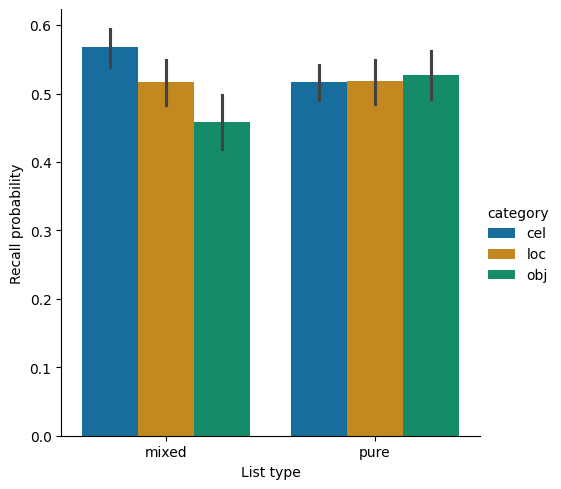

In [12]:
(
    sns.catplot(lt_cat, x="list_type", y="recall", hue="category", kind="bar", palette="colorblind")
    .set_axis_labels("List type", "Recall probability")
);

> Recall probability by list type and category. Recall was similar for the different categories in the pure lists, but differed between categories in the mixed lists. Error bars indicate 95% bootstrap confidence intervals.

### Summary statistics

We also calculate summary statistics, including mean and SEM.

In [13]:
(
    lt_cat.group_by("list_type", "category")
    .agg(
        mean=pl.col("recall").mean(),
        sem=pl.col("recall").std() / pl.col("recall").len().sqrt(),
    )
    .sort("list_type", "category")
)

list_type,category,mean,sem
str,str,f64,f64
"""mixed""","""cel""",0.567604,0.014506
"""mixed""","""loc""",0.516771,0.01691
"""mixed""","""obj""",0.457917,0.020252
"""pure""","""cel""",0.516319,0.013552
"""pure""","""loc""",0.518403,0.016545
"""pure""","""obj""",0.527431,0.017991


### Inferential statistics

To test whether list type and category, or some combination of list type and category, affects recall, we can use a two-way ANOVA. If there is a significant list type x category interaction, that means that the effect of category depends on list type (and vice-versa).

Because the list type and category variables are within-subject variables, we calculate a *repeated-measures ANOVA* using the `rm_anova` function from Pingouin. This function does not yet support Polars DataFrames, so we must first convert to Pandas format using `to_pandas`.

In [14]:
df = lt_cat.to_pandas()
pg.rm_anova(df, dv="recall", within=["list_type", "category"], subject="subject")

/Users/morton/VSCode/datascipsych/.venv/lib/python3.12/site-packages/pingouin/distribution.py:507: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  data.groupby(level=1, axis=1, observed=True, group_keys=False)
/Users/morton/VSCode/datascipsych/.venv/lib/python3.12/site-packages/pingouin/distribution.py:508: FutureWarning: DataFrameGroupBy.diff with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  .diff(axis=1)


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,list_type,0.002630,1,39,0.002630,0.995022,3.246672e-01,3.246672e-01,0.000998,1.000000
1,category,0.097177,2,78,0.048588,6.690909,2.080452e-03,3.945953e-03,0.035599,0.828202
2,list_type * category,0.146670,2,78,0.073335,49.788702,1.162971e-14,2.748265e-14,0.052772,0.969714


These results show that there is not a significant main effect of list type. There is a main effect of category. As we can tell from the bar plot, there is a large interaction effect, where category affects recall on mixed lists much more than on pure lists.

### Results

We can report our results using text like this:

> We examined whether recall varies based on list type and category using a two-way repeated-measures ANOVA with a Greenhouse-Geisser correction for non-sphericity. We found that recall varied between categories on the mixed lists, with the best recall for celebrities (mean=0.568, SEM=0.015), followed by locations (mean=0.517, SEM=0.017), then objects (mean=0.458, SEM=0.020). On pure lists, recall was similar for the different categories, with the greatest recall for objects (mean=0.527, SEM=0.018), followed by locations (mean=0.518, SEM=0.017), then celebrities (mean=0.516, SEM=0.014). There was no main effect of list type (F(1,39)=1.00, p=0.33, ng2=0.001). There was a main effect of category (F(2,78)=6.69, p=0.004, ng2=0.036). There was also a significant interaction between list type and category (F(2,78)=49.8, p=2.8x10^-14, ng2=0.053).

The Greenhouse-Geisser correction is used to avoid an assumption of standard ANOVAs that different conditions will be equally correlated with one another. In this case, the three categories may not be equally correlated, and the `p-GG-corr` column has a p-value that is corrected for this possibility.

## Correlating measures

Sometimes we have two measures that may or may not be related, and we want to examine how they *co-vary* with each other. For example, we might want to know whether differences in education tend to correlate with differences in income, or whether short-term memory capacity is related to IQ. We cannot use statistics to determine whether two variables are *causally* related, but we can check to see if they are at least *correlated*.

### Calculating measures

During the study period, participants had to make a judgment about each item when it appeared. They were asked to make a different rating depending on whether the item was a celebrity ("how much do you love or hate this person?"), a famous landmark ("how much would you like to visit this place?"), or an object ("how often do you encounter this object in your daily life?"). Say that we think participants who take longer to make responses might be processing the items more deeply, and therefore end up having better memory for those items. If our hypothesis is correct, then response time should be correlated with recall.

To test our hypothesis, let's get the mean recall and mean response time for each subject.

In [15]:
indiv = (
    data.group_by("subject")
    .agg(
        pl.col("recall").mean(),
        pl.col("response_time").mean(),
    )
    .sort("subject")
)
indiv.head()

subject,recall,response_time
i64,f64,f64
1,0.509549,0.792333
2,0.552083,1.659799
3,0.480903,1.536678
4,0.547743,1.67389
5,0.6484375,2.307194


### Visualization

We can use a scatter plot to visualize the relationship between response time and recall, along with a fit to a linear model, using `lmplot`.

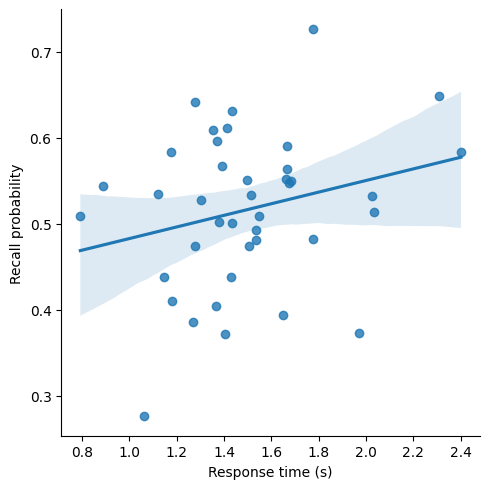

In [16]:
(
    sns.lmplot(indiv, x="response_time", y="recall")
    .set_axis_labels("Response time (s)", "Recall probability")
);

> Scatter plot showing the relationship between response time (in seconds) and recall probability across subjects. Line indicates best-fitting linear regression; confidence band indicates a 95% bootstrap confidence interval.

It seems like there might be a slight positive correlation. But is it real, or just due to chance?

### Inferential statistics

We can calculate a correlation to measure the strength of relationship between two variables. The p-value will estimate the probability of having observed a relationship at least this strong due to chance.

In [17]:
pg.corr(indiv["response_time"], indiv["recall"])

,n,r,CI95%,p-val,BF10,power
pearson,40,0.253136,"[-0.06, 0.52]",0.115026,0.653,0.356031


We find that p is greater than 0.05 and conclude that we cannot reject the null hypothesis that the relationship is due to chance.

### Results

We can use the following text to report our results:

> We examined whether response time on the encoding task was related to subsequent recall probability. We found that there was not a significant correlation (r=0.253, p=0.12).

## Summary

We demonstrated different kinds of common analyses and how they should be reported.

t-test
: compare two conditions

One-way ANOVA
: compare three or more conditions

Two-way ANOVA
: test for an interaction between two variables

Correlation
: test whether two variables co-vary

Each type of analysis involves calculating the measure(s) of interest, visualizing the results, calculating summary statistics, and calculating inferential statistics. Finally, this information is put together to write a report of the results.